In [59]:
import pandas as pd
import numpy as np
import yfinance as yf

# 獲取數據
data = yf.download('AAPL', start='2015-01-01', end='2021-01-01')

# 提取收盤價
filtered_data = data[['Close','High','Low','Volume']]

/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_59403/3720394651.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2015-01-01', end='2021-01-01')
[*********************100%***********************]  1 of 1 completed


In [60]:
data

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.261044,24.729267,23.821668,24.718171,212818400
2015-01-05,23.577578,24.110154,23.391177,24.030267,257142000
2015-01-06,23.579792,23.839422,23.218083,23.641926,263188400
2015-01-07,23.910429,24.010286,23.677426,23.788380,160423600
2015-01-08,24.829126,24.886823,24.121244,24.238856,237458000
...,...,...,...,...,...
2020-12-24,128.591019,130.042874,127.743299,127.957667,54930100
2020-12-28,133.190186,133.823537,130.091599,130.559319,124486200


In [61]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
filtered_data['Close'] = scaler.fit_transform(data[['Close']])

/var/folders/2d/q366jpls0tn7mdr8lg1zq2k40000gn/T/ipykernel_59403/2159125135.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Close'] = scaler.fit_transform(data[['Close']])


In [62]:
def create_sequences(dataset, lookback=60):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        X.append(dataset[i:(i + lookback), 0])
        y.append(dataset[i + lookback, 0])
    return np.array(X), np.array(y)

# 轉換為 numpy 陣列
dataset = data.values

# 定義 lookback 窗口大小
lookback = 60

X, y = create_sequences(dataset, lookback)

In [63]:
# 劃分比例
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [64]:
# 將數據轉換為 PyTorch 張量
import torch

X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

# 調整輸入形狀為 (seq_length, batch_size, feature_size)
X_train_tensor = X_train_tensor.unsqueeze(-1).permute(1, 0, 2)
X_test_tensor = X_test_tensor.unsqueeze(-1).permute(1, 0, 2)

In [65]:
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用設備：{device}')

使用設備：cpu


In [66]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # 建立一個位置編碼矩陣
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶數位置
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇數位置
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x 的形狀為 (seq_length, batch_size, d_model)
        x = x + self.pe[:x.size(0)]
        return x

In [67]:
class TransformerTimeSeries(nn.Module):
    def __init__(self, feature_size=1, num_layers=2, nhead=4, hidden_dim=128, dropout=0.1):
        super(TransformerTimeSeries, self).__init__()
        self.model_type = 'Transformer'
        self.input_linear = nn.Linear(feature_size, hidden_dim)  # 新增的線性層
        self.pos_encoder = PositionalEncoding(d_model=hidden_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.decoder = nn.Linear(hidden_dim, 1)
        self.hidden_dim = hidden_dim

    def forward(self, src):
        # src 形狀: (seq_length, batch_size, feature_size)
        src = self.input_linear(src)  # 將輸入映射到 hidden_dim 維度
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        # 取最後一個時間步的輸出
        output = self.decoder(output[-1, :, :])
        return output

In [68]:
feature_size = 1  # 輸入特徵數
num_layers = 2
nhead = 4
hidden_dim = 128

model = TransformerTimeSeries(feature_size=feature_size, num_layers=num_layers, nhead=nhead, hidden_dim=hidden_dim).to(device)

/Users/hongjiayu/miniconda3/envs/intern/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [69]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [70]:
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [71]:
num_epochs = 100
batch_size = X_train_tensor.size(1)

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            test_output = model(X_test_tensor)
            test_loss = criterion(test_output.squeeze(), y_test_tensor)
        print(f'Epoch [{epoch + 1}/{num_epochs}], 訓練集 Loss: {loss.item():.4f}, 測試集 Loss: {test_loss.item():.4f}')

Epoch [5/100], 訓練集 Loss: 1055.7233, 測試集 Loss: 7452.3223
Epoch [10/100], 訓練集 Loss: 929.5269, 測試集 Loss: 7183.5020
Epoch [15/100], 訓練集 Loss: 893.1594, 測試集 Loss: 7088.8984
Epoch [20/100], 訓練集 Loss: 858.2031, 測試集 Loss: 6984.5068
Epoch [25/100], 訓練集 Loss: 821.6813, 測試集 Loss: 6876.9346
Epoch [30/100], 訓練集 Loss: 787.1194, 測試集 Loss: 6771.9497
Epoch [35/100], 訓練集 Loss: 752.7431, 測試集 Loss: 6666.5454
Epoch [40/100], 訓練集 Loss: 718.3335, 測試集 Loss: 6558.1987
Epoch [45/100], 訓練集 Loss: 684.1658, 測試集 Loss: 6448.6528
Epoch [50/100], 訓練集 Loss: 650.3031, 測試集 Loss: 6338.4761
Epoch [55/100], 訓練集 Loss: 617.0331, 測試集 Loss: 6227.2939
Epoch [60/100], 訓練集 Loss: 584.0492, 測試集 Loss: 6115.3481
Epoch [65/100], 訓練集 Loss: 551.8002, 測試集 Loss: 6002.8481
Epoch [70/100], 訓練集 Loss: 520.3436, 測試集 Loss: 5890.1392
Epoch [75/100], 訓練集 Loss: 489.7625, 測試集 Loss: 5777.1538
Epoch [80/100], 訓練集 Loss: 459.7466, 測試集 Loss: 5664.4482
Epoch [85/100], 訓練集 Loss: 430.8750, 測試集 Loss: 5551.9341
Epoch [90/100], 訓練集 Loss: 403.0538, 測試集 Loss: 54

In [72]:
model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensor).cpu().numpy()
    test_predict = model(X_test_tensor).cpu().numpy()

# 反歸一化
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(y_train_tensor.cpu().numpy().reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1))

/Users/hongjiayu/miniconda3/envs/intern/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20729 (\N{CJK UNIFIED IDEOGRAPH-50F9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hongjiayu/miniconda3/envs/intern/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hongjiayu/miniconda3/envs/intern/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hongjiayu/miniconda3/envs/intern/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hongjiayu/miniconda3/envs/intern/lib/python3.10/site-

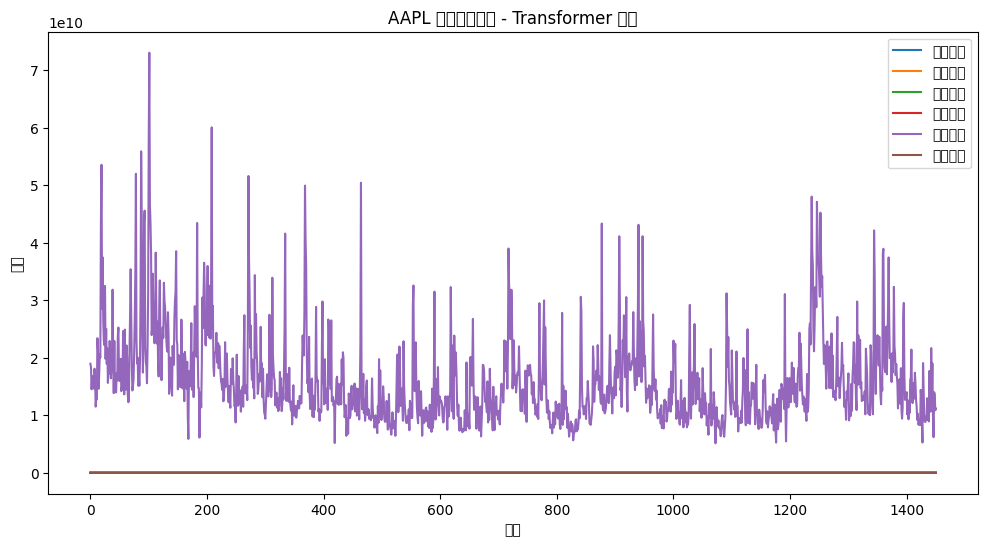

In [73]:
import matplotlib.pyplot as plt

# 構建完整的時間序列
predicted = np.concatenate((train_predict, test_predict), axis=0)
actual = scaler.inverse_transform(dataset[lookback:])

plt.figure(figsize=(12,6))
plt.plot(actual, label='實際價格')
plt.plot(predicted, label='預測價格')
plt.title('AAPL 股票價格預測 - Transformer 模型')
plt.xlabel('時間')
plt.ylabel('價格')
plt.legend()
plt.show()

In [74]:
from sklearn.metrics import mean_squared_error

train_score = mean_squared_error(y_train_actual, train_predict)
test_score = mean_squared_error(y_test_actual, test_predict)
print(f'訓練集 MSE: {train_score:.2f}')
print(f'測試集 MSE: {test_score:.2f}')

訓練集 MSE: 4280705.00
測試集 MSE: 66136536.00
